<h2 style="text-align: center;">Generalized method of moments</h2>


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy.optimize import minimize
from scipy.special import comb  # For binomial coefficients


In [2]:
class Vasicek:
    def __init__(self, kappa, theta, sigma):
        """
        Initialize the parameters for the Vasicek model.
        
        :param kappa: Speed of mean reversion
        :param theta: Long-term mean level
        :param sigma: Volatility of the process
        """
        self.kappa = kappa
        self.theta = theta
        self.sigma = sigma

    def generate(self, X0, T, N, n):
        """
        Generate N trajectories of the Vasicek process on the interval [0, T] with a time step of T/n.
        
        :param X0: Initial value of the process
        :param T: The total time period
        :param N: Number of trajectories to generate
        :param n: Number of discretization steps (so time step is T/n)
        
        :return: Array of N trajectories discretized over the interval [0, T]
        """
        dt = T / n  # Adjusted time step for the interval [0, T]
        trajectories = np.zeros((N, n))  # Matrix to store the trajectories
        trajectories[:, 0] = X0  # Initialize all trajectories at X0

        for i in range(1, n):
            # Generate standard normal noise
            Z = np.random.randn(N)  # Standard normal random variables for each trajectory
            # Update the process value according to the Vasicek model
            trajectories[:, i] = (
                trajectories[:, i - 1] * np.exp(-self.kappa * dt)
                + self.theta * (1 - np.exp(-self.kappa * dt))
                + self.sigma * np.sqrt((1 - np.exp(-2 * self.kappa * dt)) / (2 * self.kappa)) * Z
            )

        return trajectories


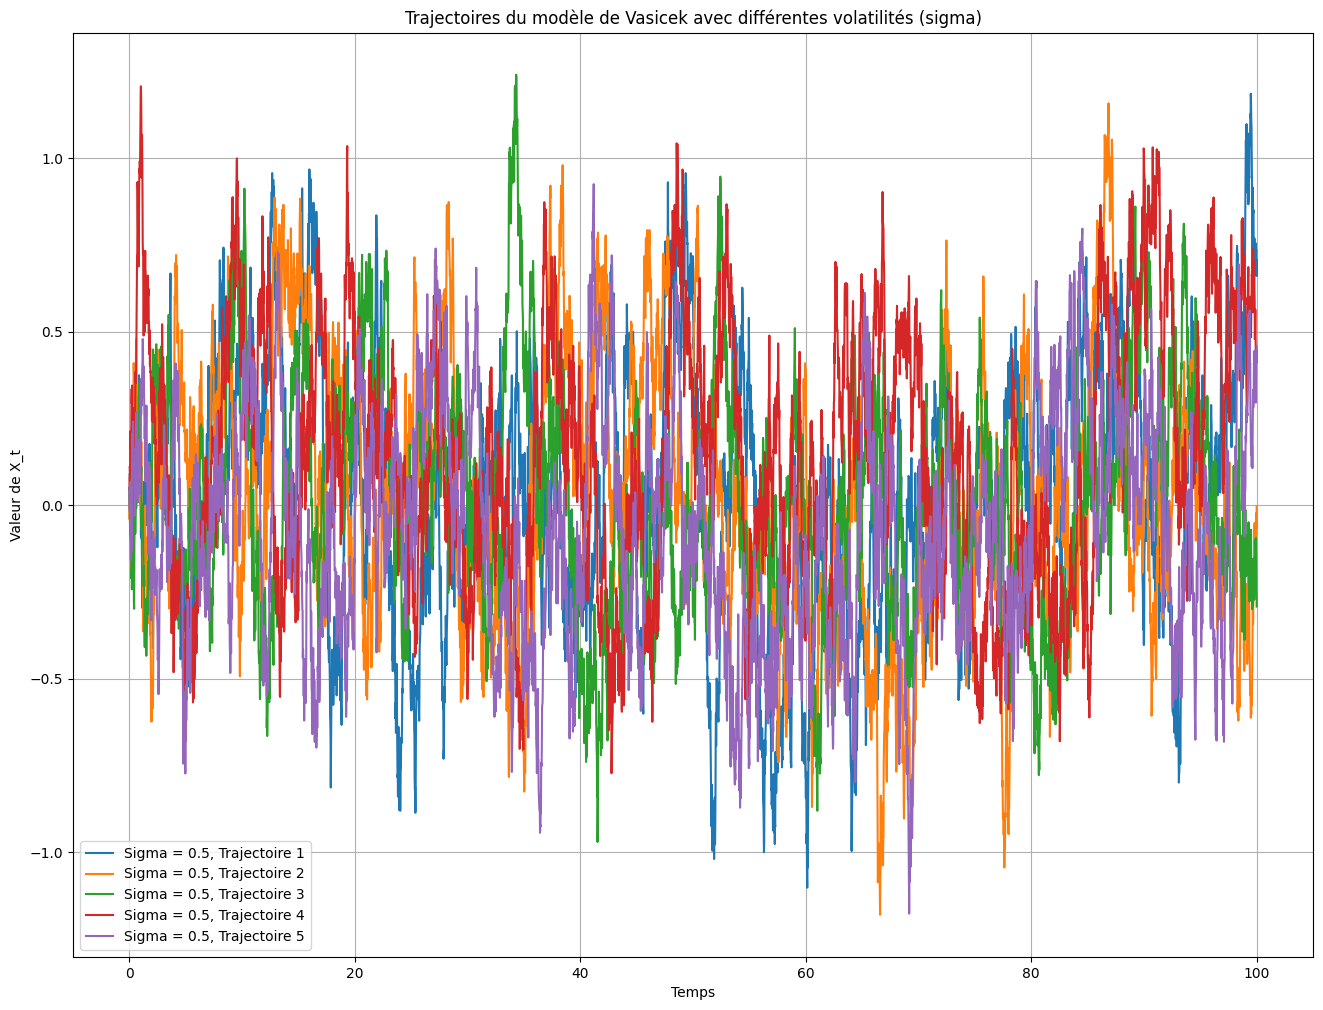

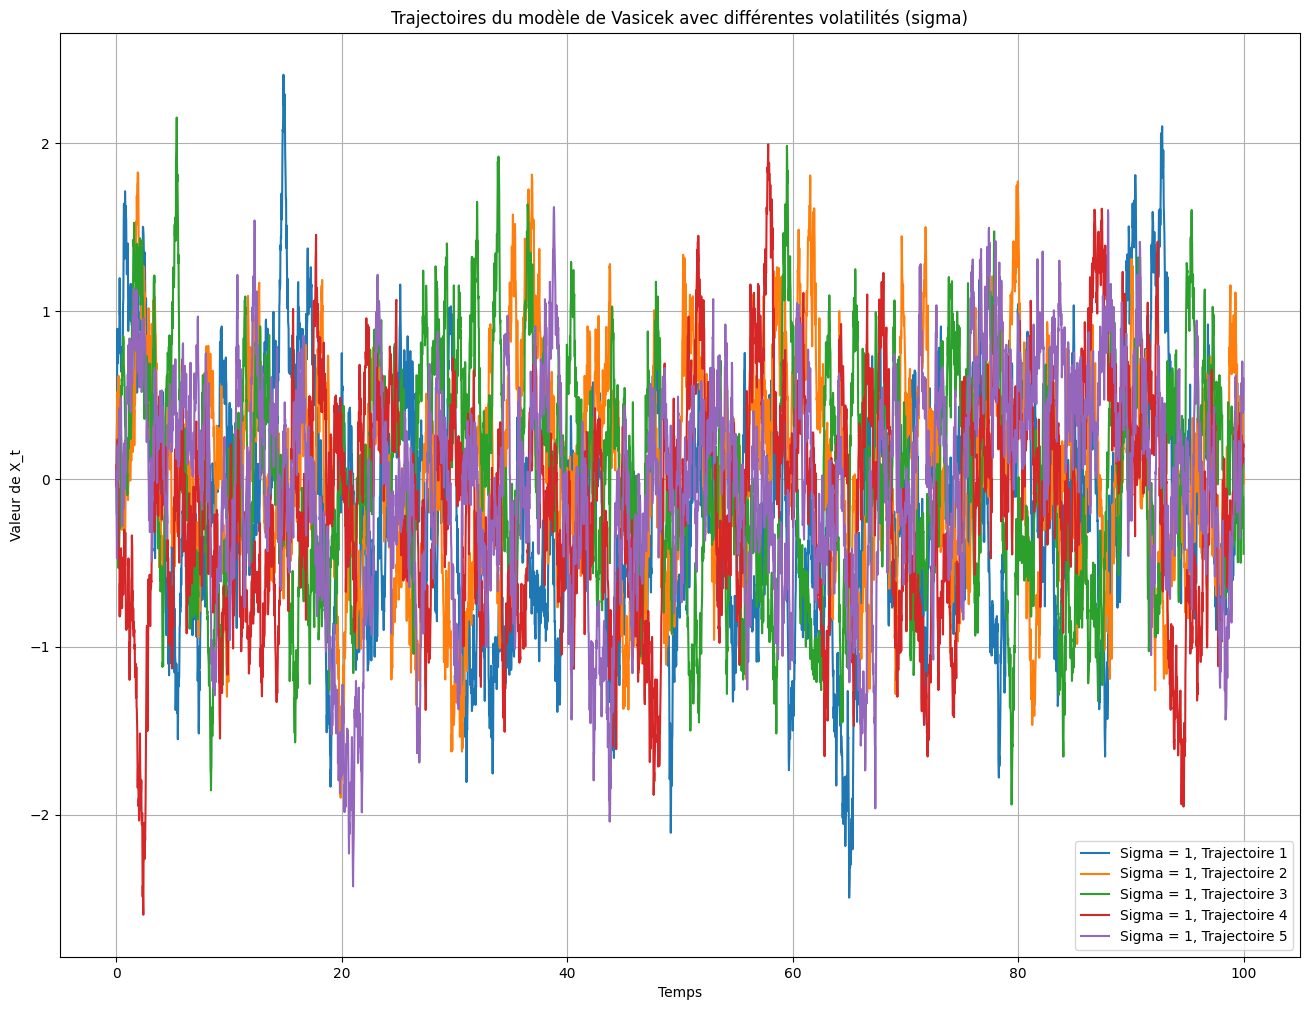

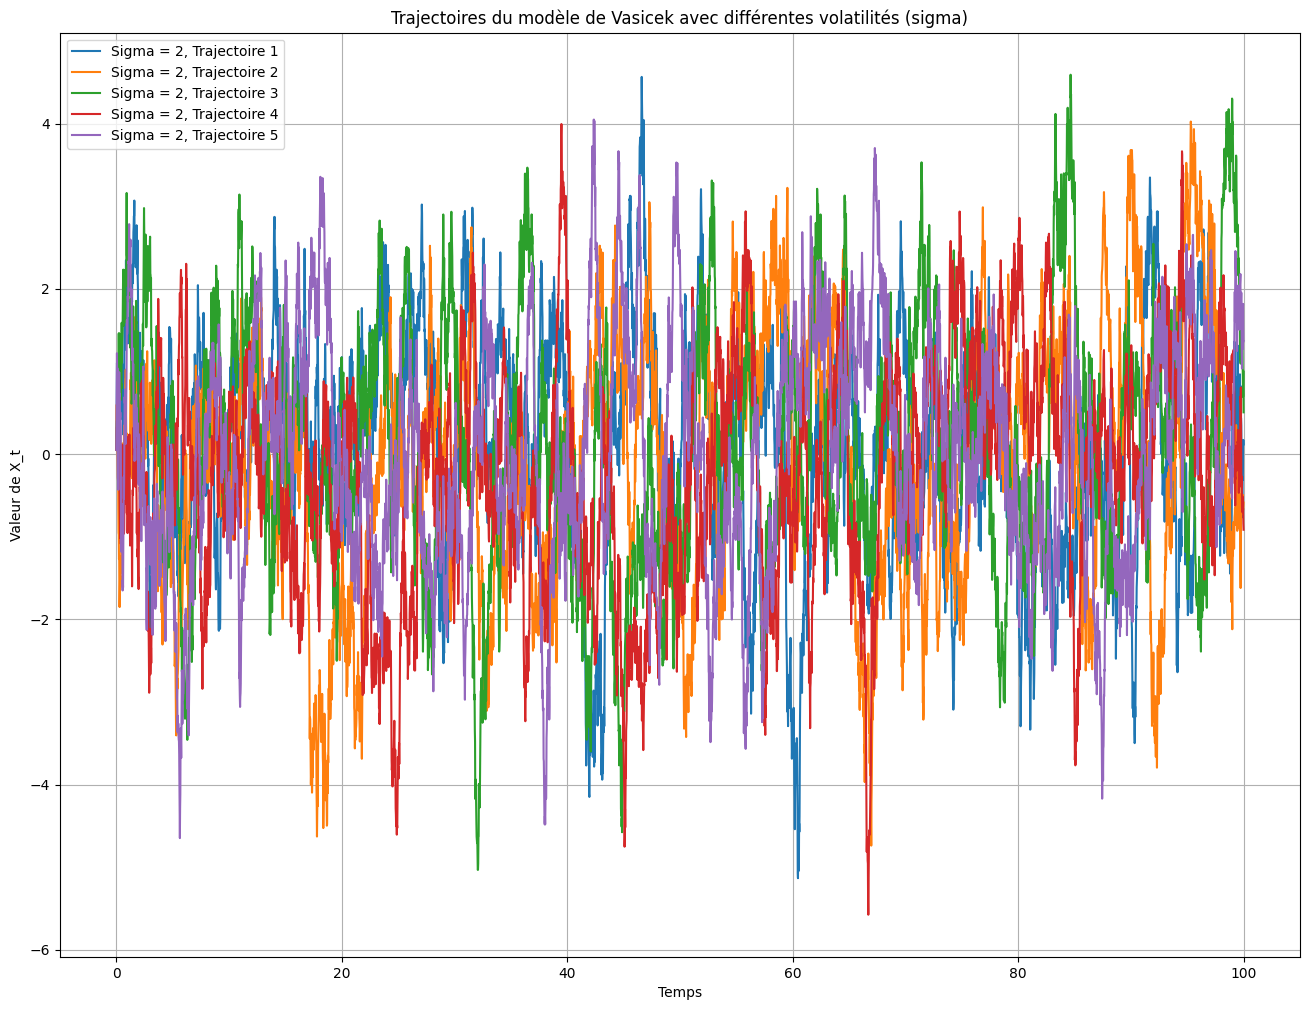

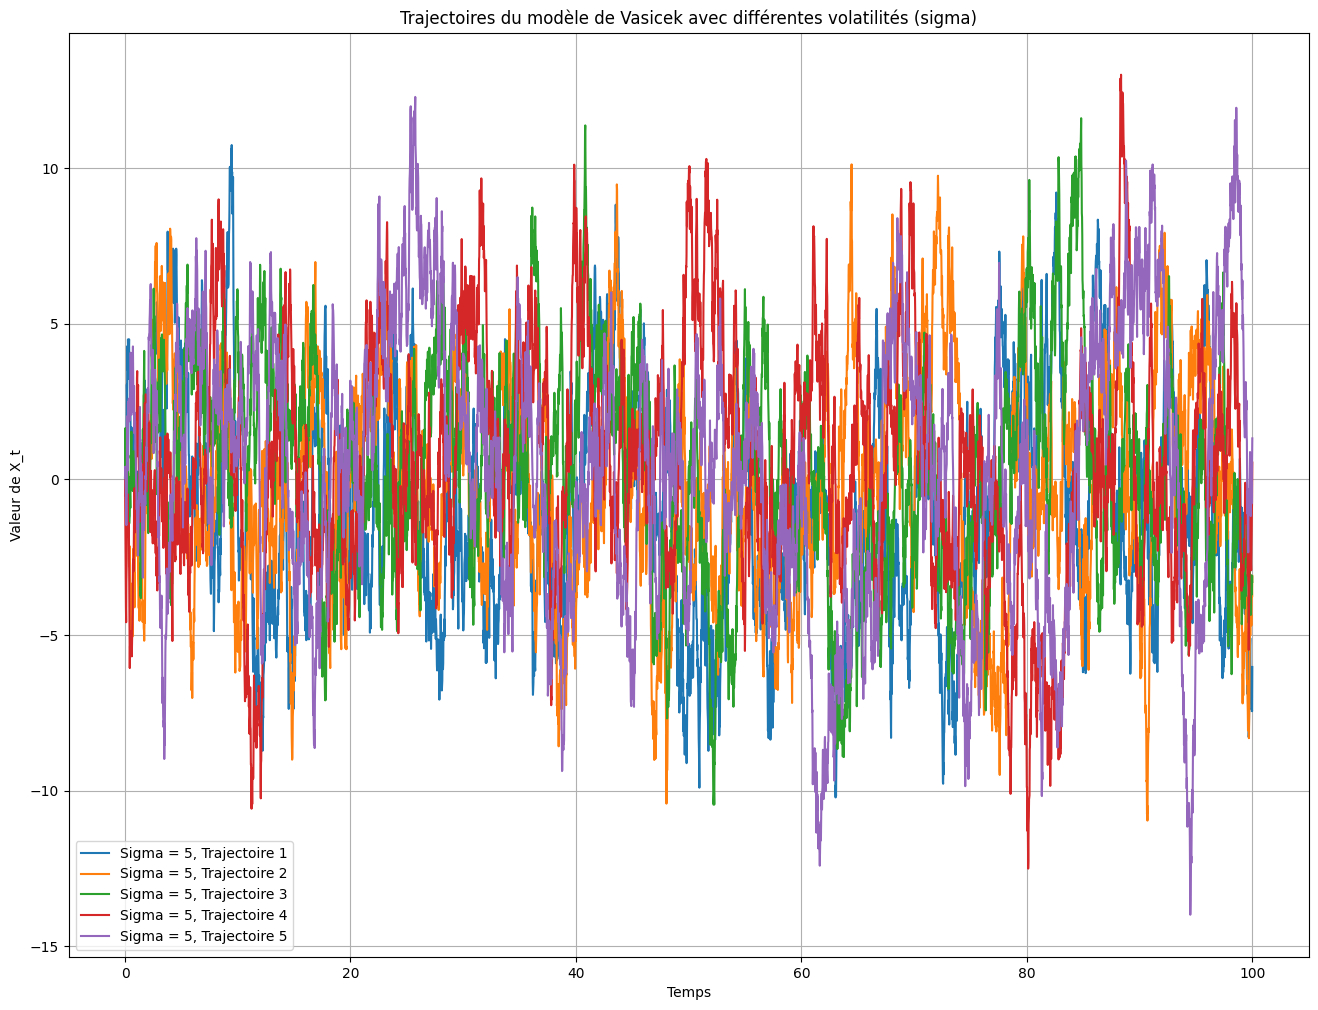

In [3]:
# Paramètres du modèle de Vasicek
kappa = 1  # vitesse de réversion vers la moyenne
theta = 0  # niveau de la moyenne à long terme
X0 = 0.05  # valeur initiale
N = 5  # nombre de trajectoires à générer
n = 5000  # nombre de pas de discrétisation
T = 100  # durée totale

# Liste des valeurs de sigma
sigma_values = [0.5, 1, 2, 5]

# Créer un objet de la classe Vasicek et générer les trajectoires pour chaque valeur de sigma
for sigma in sigma_values:
    # Créer un objet avec la valeur de sigma courante
    plt.figure(figsize=(16, 12))
    vasicek_process = Vasicek(kappa, theta, sigma)
    
    # Générer les trajectoires
    trajectories = vasicek_process.generate(X0, T, N, n)  # Correction: Pass X0, T, N, n
    
    # Affichage des trajectoires générées pour chaque sigma
    time = np.linspace(0, T, n)
    for i in range(N):
        plt.plot(time, trajectories[i], label=f"Sigma = {sigma}, Trajectoire {i+1}")
    plt.title("Trajectoires du modèle de Vasicek avec différentes volatilités (sigma)")
    plt.xlabel("Temps")
    plt.ylabel("Valeur de X_t")
    plt.legend()
    plt.grid(True)
    plt.show()


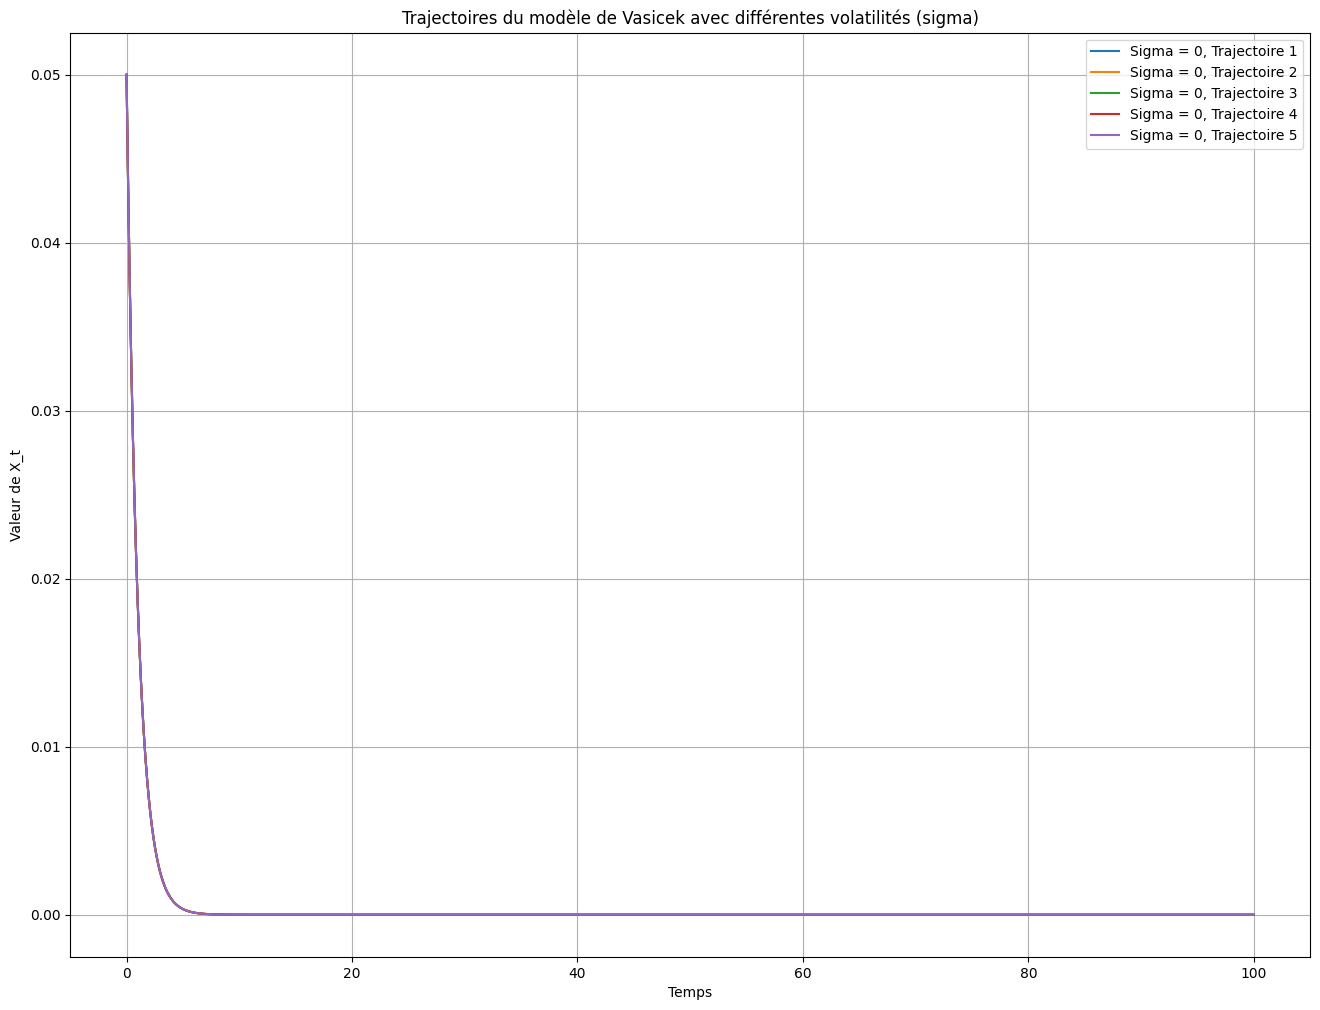

In [4]:
# Paramètres du modèle de Vasicek
kappa = 1  # vitesse de réversion vers la moyenne
theta = 0  # niveau de la moyenne à long terme
X0 = 0.05  # valeur initiale
N = 5  # nombre de trajectoires à générer
n = 5000  # nombre de pas de discrétisation
T = 100  # durée totale

# Liste des valeurs de sigma
sigma_values = [0]

# Créer un objet de la classe Vasicek et générer les trajectoires pour chaque valeur de sigma
for sigma in sigma_values:
    # Créer un objet avec la valeur de sigma courante
    plt.figure(figsize=(16, 12))
    vasicek_process = Vasicek(kappa, theta, sigma)
    
    # Générer les trajectoires
    trajectories = vasicek_process.generate(X0, T, N, n)  # Correction: Pass X0, T, N, n
    
    # Affichage des trajectoires générées pour chaque sigma
    time = np.linspace(0, T, n)
    for i in range(N):
        plt.plot(time, trajectories[i], label=f"Sigma = {sigma}, Trajectoire {i+1}")
    
    plt.title("Trajectoires du modèle de Vasicek avec différentes volatilités (sigma)")
    plt.xlabel("Temps")
    plt.ylabel("Valeur de X_t")
    plt.legend()
    plt.grid(True)
    plt.show()

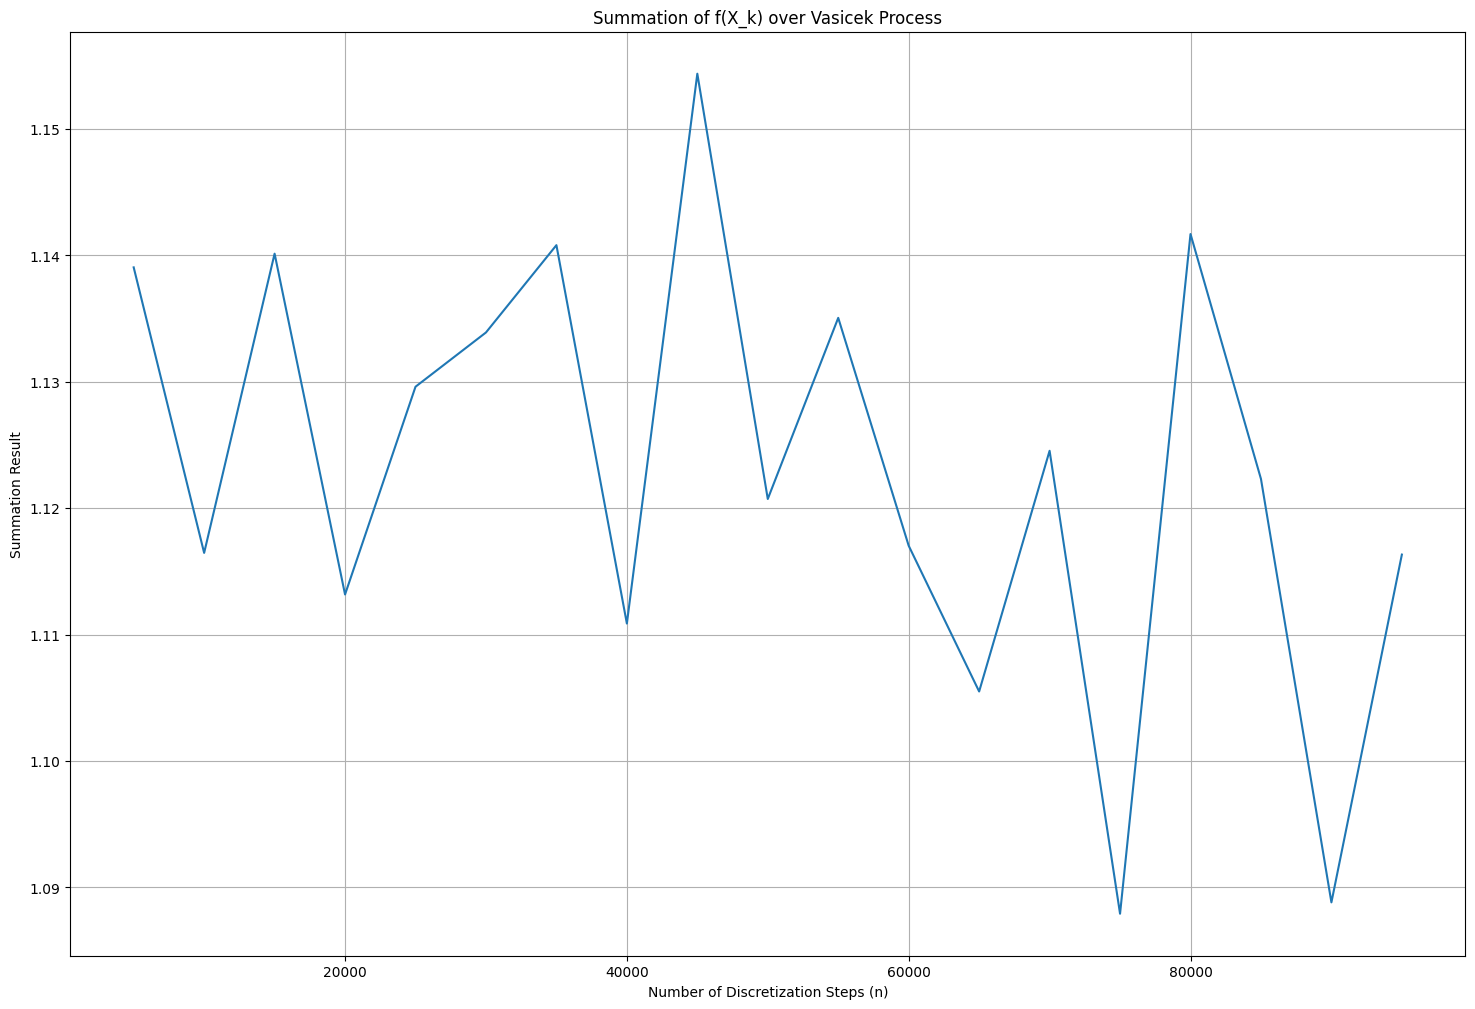

In [5]:
def calculate_sum(n, f, kappa=1, theta=1, sigma=0.5, X0=0.05,T=5000):
    """
    Calculate the summation: (1/n) * sum_{k=0}^n f(X_k), where X_k is generated by the Vasicek model.
    
    :param n: Number of steps in the discretization
    :param f: Function to apply to each X_k
    :param kappa: Speed of mean reversion
    :param theta: Long-term mean level
    :param sigma: Volatility
    :param X0: Initial value of the process
    :return: The computed summation
    """
    vasicek_process = Vasicek(kappa, theta, sigma)
      # Time horizon

    # Generate one trajectory
    trajectories = vasicek_process.generate(X0, T, 1, n)  # One trajectory, n steps
    res = 0
    trajectory = trajectories[0]  # Take the first trajectory
    res +=(1 / n) * sum(f(x) for x in trajectory)
    # Compute the summation
    return res

# Define the function to apply to each X_k
f = lambda x: x**2  # Example: Square of each value

n_values = range(5000, 100000, 5000)  # Range of n values for testing
Y = [calculate_sum(n, f) for n in n_values]  # Compute the result for each n

# Plot the results
plt.figure(figsize=(18, 12))
plt.plot(n_values, Y)
plt.xlabel("Number of Discretization Steps (n)")
plt.ylabel("Summation Result")
plt.title("Summation of f(X_k) over Vasicek Process")
plt.grid(True)
plt.show()

In [6]:
def expected_value_vasicek(power, theta, sigma, kappa):
    """
    Compute the expected value of the Vasicek process at X_n using the closed-form formula.
    
    :param n: Number of steps in the discretization
    :param theta: Long-term mean level
    :param sigma: Volatility
    :param kappa: Speed of mean reversion
    :return: The theoretical expected value
    """
    expected_sum = 0
    for k in range(power + 1):
        # Binomial coefficient
        binom_coeff = comb(power, k)
        
        # Factor for theta and sigma
        theta_factor = theta**(power - k)
        sigma_factor = sigma**k / (2 * kappa)**(k//2)
        
        # Expectation of Z^k
        if k % 2 == 0:  # Even powers of Z
            m = k // 2
            # For even k, the expectation of Z^{2m} is (2m-1)!! = (2m-1)*(2m-3)*...*1
            z_expectation = math.factorial(2 * m) // (2**m * math.factorial(m))  # Double factorial calculation
        else:  # Odd powers of Z
            z_expectation = 0
        
        # Add to the summation
        expected_sum += binom_coeff * theta_factor * sigma_factor * z_expectation
    
    return expected_sum


# Parameters for Vasicek
theta = 0
sigma = 0
kappa = 1
n = 2

# Compute theoretical expectation
true_value = expected_value_vasicek(n, theta, sigma, kappa)
print("Theoretical Expected Value:", true_value)


Theoretical Expected Value: 0.0


Theoretical Expected Value: 1.0
Average of computed Summation: 0.9997058883302818


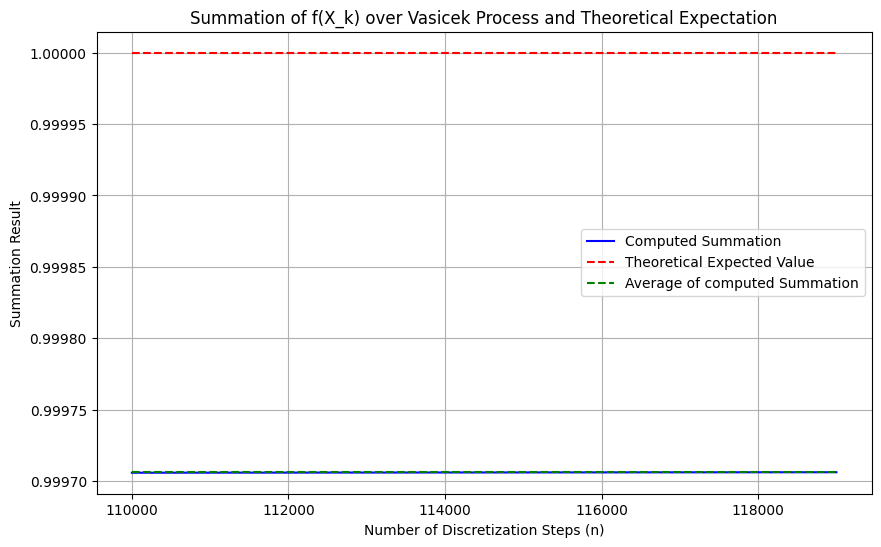

In [7]:

# Example parameters
kappa = 1  # Speed of mean reversion
theta = 1  # Long-term mean level
sigma = 0  # Volatility
X0 = 0.05  # Initial value
N = 1  # Only 1 trajectory for the summation computation
n_values = range(110000, 120000, 1000)  # Range of n values for testing
n = 2 # Choose a large n for comparison

# Define the function to apply to each X_k
f = lambda x: x**n# Example: x^3

# Compute the summation for each value of n
Y = [calculate_sum(n, f, kappa=kappa, theta=theta, sigma=sigma, X0=X0) for n in n_values]
y0 = sum(Y)/len(Y)
# Compute the true value of the expectation
true_value = expected_value_vasicek(n, theta, sigma, kappa)
Y0 = [true_value for _ in n_values]  # Create a constant list for the theoretical expected value
Y1 = [y0 for _ in n_values]
# Print the theoretical expected value
print("Theoretical Expected Value:", true_value)
print("Average of computed Summation:", y0)
# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(n_values, Y, label="Computed Summation", color="blue")
plt.plot(n_values, Y0, label="Theoretical Expected Value", color="red", linestyle="--")
plt.plot(n_values, Y1, label="Average of computed Summation", color="green", linestyle="--")
plt.xlabel("Number of Discretization Steps (n)")
plt.ylabel("Summation Result")
plt.title("Summation of f(X_k) over Vasicek Process and Theoretical Expectation")
plt.legend()
plt.grid(True)
plt.show()


In [8]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
# Number of moments to generate
number_of_moments = 10
# True values for parameters
theta_true = 0
sigma_true = 0.5
kappa_true = 1
L = []
# Generate synthetic data
Z_true = np.zeros(number_of_moments)
for i in range(number_of_moments):
    Z_true[i] = expected_value_vasicek(i + 1, theta_true, sigma_true, kappa_true)

def parameter_estimator():
    """Generalized Method of Moments estimator for the Vasicek model."""
    def matrix_calculator(params):
        theta, sigma, kappa = params
        # Initialize Z and Y arrays
        Z = np.zeros(number_of_moments)
        Y = np.zeros(number_of_moments)
        
        # Compute Z values
        for i in range(number_of_moments):
            Z[i] = expected_value_vasicek(i + 1, theta, sigma, kappa)
        
        # Compute Y values
        for i in range(number_of_moments):
            Y[i] = calculate_sum(100000, lambda x: x ** (i + 1), kappa=kappa, theta=theta, sigma=sigma, X0=0.05)

        # Compute the difference and return the sum of squares
        diff = Y - Z_true
        return np.dot(diff, diff)
    
    # Initial guess for [theta, sigma, kappa]
    initial_guess = [0.5, 0.7, 1.1]
    
    # Perform minimization
    res = minimize(matrix_calculator, initial_guess, method='BFGS', 
                   options={'xatol': 1e-1, 'disp': True, 'maxfev': 10000})    
    
    # Output the results
    print("Optimization Success:", res.success)   # Check if optimization succeeded
    print("Optimization Message:", res.message)   # Check why it may have failed
    print("Final Objective Function Value:", res.fun)  # Final value of the objective function
    print("Optimized Parameters:", res.x)         # Optimized parameters (theta, sigma, kappa)
    
    return res.x

# Example usage
(parameter_estimator())


/tmp/ipykernel_267246/573850864.py:40: OptimizeWarning: Unknown solver options: xatol, maxfev
  res = minimize(matrix_calculator, initial_guess, method='BFGS',


         Current function value: 47.084633
         Iterations: 2
         Function evaluations: 76
         Gradient evaluations: 16
Optimization Success: False
Optimization Message: Desired error not necessarily achieved due to precision loss.
Final Objective Function Value: 47.084633079093194
Optimized Parameters: [0.50000035 0.70000042 1.10000005]


/home/hassene/.local/lib/python3.10/site-packages/scipy/optimize/_minimize.py:726: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


array([0.50000035, 0.70000042, 1.10000005])

<h1>Maximum Likelihood Estimator (MLE)</h1>

<p>We aim to prove the Maximum Likelihood Estimator (MLE) of the Vasicek model and then implement it. Afterward, we will compare the results with those obtained using our first method.</p>

<p>The Vasicek model is described by the stochastic differential equation (SDE):</p>

$$
dX_t = \kappa (\theta - X_t) \, dt + \sigma \, dW_t
$$

$$
\alpha = \kappa, \, \theta = r, \, \Delta t = t_i - t_{i-1}
$$

$$
\mathbb{E}[X_{t_i}] = X_{t_{i-1}} e^{-\kappa \Delta t} + \theta(1 - e^{-\kappa \Delta t})
$$

$$
\text{Var}[X_{t_i}] = \frac{\sigma^2}{2\kappa} \left(1 - e^{-2\kappa \Delta t}\right)
$$

$$
L(\theta) = L(\kappa, \theta, \sigma^2) = -\frac{n}{2} \log \left( \frac{\sigma^2}{2\kappa} \left(1 - e^{-2\kappa \Delta t}\right) \right)
- \frac{n}{2} \log 2\pi - \frac{\kappa}{\sigma^2 (1 - e^{-2\kappa \Delta t})}
\sum_{i=1}^{n} \left( X_{t_i} - X_{t_{i-1}} e^{-\kappa \Delta t} - \theta \left(1 - e^{-\kappa \Delta t}\right) \right)^2
$$








<p><b>Bibliography:</b></p>

<p>Maximum Likelihood calibration of the Vasicek model to the Swedish interest rate market<br>
MVEX01-18-12<br>
Kandidatarbete inom civilingenjörsutbildningen vid Chalmers<br>
Axel Gerebrink, Justin Lundgren, Fredrik Malmström, Oscar Thorén</p>


In [9]:
true_kappa = 1.2
true_theta = 0.1
true_sigma = 0.1
n= 500000
T= 50
vasicek_process = Vasicek(true_kappa, true_theta, true_sigma)
    # Generate one trajectory of the process
trajectories = vasicek_process.generate(0.05, T, 1, n)  # One trajectory, n steps
trajectory = trajectories[0] 

In [10]:

def negative_log_likelihood(params):
    """
    Compute the log-likelihood for the Vasicek process given parameters.
    
    :param sigma: Volatility parameter (standard deviation)
    :param theta: Long-term mean level
    :param kappa: Speed of mean reversion
    :param n: Number of discretization steps
    :param T: Total time period (default is 1)
    
    :return: Log-likelihood value
    """
    # Create the Vasicek process model with given parameters
 # Take the first trajectory as the observed data
    sigma, theta, kappa = params

    dt = T / n  # Time step size

    # Initialize log-likelihood value
    log_likelihood_value = 0

    # First part of the log-likelihood
    term1 = -n / 2 * np.log(sigma**2 / (2 * kappa * (1 - np.exp(-2 * kappa * dt))))
    log_likelihood_value += term1
    # Third part: Sum of squared residuals
    residual_sum = 0
    for i in range(1, n):
        expected_value = trajectory[i - 1] * np.exp(-kappa * dt) + theta * (1 - np.exp(-kappa * dt))
        residual = trajectory[i] - expected_value
        residual_sum += residual**2
    
    # Fourth part: the sum over residuals
    term3 = -(kappa / (sigma**2 * (1 - np.exp(-2 * kappa * dt)))) * residual_sum
    log_likelihood_value += term3

    return -log_likelihood_value


# Example usage:
true_kappa = 1.2
true_theta = 0.1
true_sigma = 0.1
kappa = .1
theta = 0
sigma = 0.02
T = 5000  # Total time period
n = 50000  # Number of discretization steps
params = [sigma, theta, kappa]
# Calculate the log-likelihood for the given parameters
log_likelihood_value = negative_log_likelihood(params)

# Print the log-likelihood value
Log_Likelihood =  1552684184.106048
print(f"Log-Likelihood: {log_likelihood_value/1000000:.6f}e6")


Log-Likelihood: -0.055302e6


In [11]:
from scipy.optimize import minimize

# Example: true values are sigma = 0.02, theta = 0.05, kappa = 0.1

# Initial guesses for [sigma, theta, kappa]
initial_guess = [0.05, 0.5, 0.3]

# Define parameter bounds
# sigma and kappa should be positive (e.g., in range [1e-5, 1])
# theta has no explicit bounds
parameter_bounds = [(1e-5, 5), (1e-5, 5), (1e-5, 5)]

# Minimize the negative log-likelihood
result = minimize(
    negative_log_likelihood, 
    initial_guess, 
    bounds=parameter_bounds
)

# Check if minimization was successful
if result.success:
    mle_sigma, mle_theta, mle_kappa = result.x

    # Display MLE estimates
    print(f"Maximum Likelihood Estimates (MLE):")
    print(f"  Sigma: {mle_sigma}")
    print(f"  Theta: {mle_theta}")
    print(f"  Kappa: {mle_kappa}")
else:
    print("Minimization failed:", result.message)

# Display the full result for debugging or analysis
print("Optimization Result:", result)


print(negative_log_likelihood([mle_sigma, mle_theta, mle_kappa]))

Maximum Likelihood Estimates (MLE):
  Sigma: 0.01624301918216794
  Theta: 0.13450479904660892
  Kappa: 0.7897419512550673
Optimization Result:   message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: -144346.48163846968
        x: [ 1.624e-02  1.345e-01  7.897e-01]
      nit: 15
      jac: [-1.554e+00 -1.254e+00 -2.328e-02]
     nfev: 116
     njev: 29
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
-144346.48163846968


In [ ]:
true_kappa = 1.2
true_theta = 0.1
true_sigma = 0.1
n= 20000000
T= 5000
vasicek_process = Vasicek(true_kappa, true_theta, true_sigma)
    # Generate one trajectory of the process
trajectories = vasicek_process.generate(0.05, T, 1, n)  # One trajectory, n steps
trajectory = trajectories[0] 
def estimate_parameters(trajectory = trajectory, T = T):
    n = len(trajectory)
    delta_t = T / n
    Rt = np.array(trajectory)
    
    # Calculate terms
    Rt_shifted = Rt[:-1]  # R_{t_{i-1}}
    Rt_current = Rt[1:]  # R_{t_i}
    
    #  (kappa)
    mean_RtRt_shifted = np.mean(Rt_current * Rt_shifted)
    mean_Rt = np.mean(Rt_current)
    mean_Rt_shifted = np.mean(Rt_shifted)
    mean_Rt_shifted_squared = np.mean(Rt_shifted ** 2)
    
    numerator_alpha = mean_RtRt_shifted - mean_Rt * mean_Rt_shifted
    denominator_alpha = mean_Rt_shifted_squared - mean_Rt_shifted ** 2
    kappa = -1 / delta_t * np.log(numerator_alpha / denominator_alpha)
    
    #  (theta)
    numerator_theta = np.sum(Rt_current) - np.exp(kappa * delta_t) * np.sum(Rt_shifted)
    denominator_theta = n * (1 - np.exp(-kappa * delta_t))
    theta = numerator_theta / denominator_theta
    
    # sigma^2
    term1 = Rt_current - Rt_shifted * np.exp(-kappa * delta_t)
    term2 = theta * (1 - np.exp(-kappa * delta_t))
    sigma_squared = (2 * kappa) / (n * (1 - np.exp(-2 * kappa * delta_t))) * np.sum((term1 - term2) ** 2)
    
    return kappa, theta, sigma_squared
kappa, theta, sigma = estimate_parameters()
print('kappa is ', kappa)
print('theta is ', theta)
print('sigma is ', sigma)
print('true kappa is ', true_kappa)
print('true theta is ', true_theta)
print('true sigma is', true_sigma)